In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_tools import CreateDataset_2, train_model_cls, plot_metrics, show_augmentations

/Users/aleksejkitajskij/Desktop/DS-Lifehacks/pytorch/pytorch_tools.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_path = '../data/Module_3_Lecture_1_SIGNS_dataset/'
splits = ['train', 'test']

In [3]:
train_transformer = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

test_transformer = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

/opt/anaconda3/envs/goit/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
train_dataset = CreateDataset_2(f'{data_path}train_signs/', train_transformer, augmentations_per_image=2)
test_dataset = CreateDataset_2(f'{data_path}test_signs/', test_transformer, augmentations_per_image=0)

FileNotFoundError: [Errno 2] No such file or directory: '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/'

# аналіз аугументації

In [5]:
train_dataset.filenames[:10]

['../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5556.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5556.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5556.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/3_IMG_6138.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/3_IMG_6138.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/3_IMG_6138.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5542.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5542.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5542.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/3_IMG_6104.jpg']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


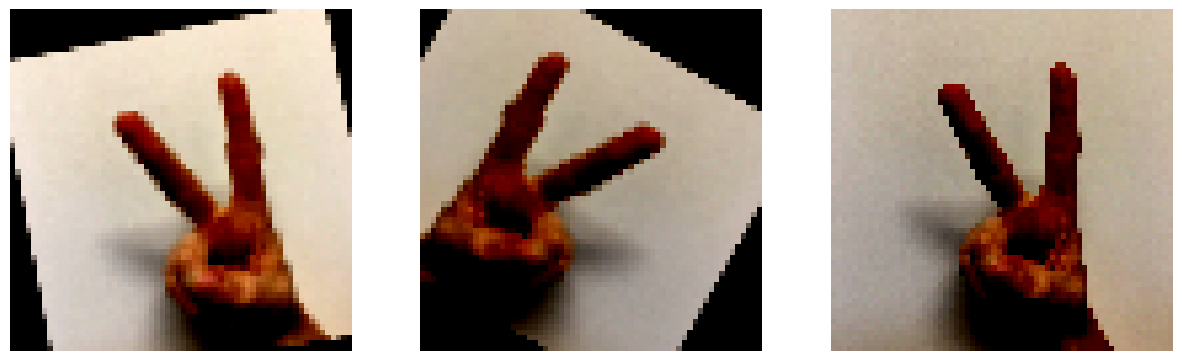

In [15]:
show_augmentations(train_transformer, train_dataset.filenames)

# побудова моделі

In [7]:
class BaselineModel(nn.Module):

    def __init__(self, ): 
        super().__init__()
        self.num_channels = 32
        
        # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
        # stride, padding). We also include batch normalisation layers that help stabilise training.

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)       

    def forward(self, s):
        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.conv1(s)                                   # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.conv2(s)                                   # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.conv3(s)                                   # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.relu(self.fc1(s))                             # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)


In [8]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=32, 
                              shuffle=True,
                              num_workers=0)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32, 
                             shuffle=False,
                             num_workers=0)

In [9]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Використовується пристрій:", device)

Використовується пристрій: mps


In [10]:
model = BaselineModel().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [11]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [12]:
metrics, model = train_model_cls(num_classes=6,
                                num_epoch=10,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                model=model,
                                criterion=criterion,
                                optimizer=optimizer,
                                device=device,
                                info_every_iter=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 1.4854 Acc: 0.3864 Rec: 0.3864 Prec: 0.4179
Epoch [2/10] Train Loss: 0.8731 Acc: 0.6793 Rec: 0.6793 Prec: 0.6770
Epoch [3/10] Train Loss: 0.6517 Acc: 0.7673 Rec: 0.7673 Prec: 0.7657
Epoch [4/10] Train Loss: 0.5160 Acc: 0.8074 Rec: 0.8074 Prec: 0.8062
Epoch [5/10] Train Loss: 0.4410 Acc: 0.8386 Rec: 0.8386 Prec: 0.8380
Epoch [6/10] Train Loss: 0.3493 Acc: 0.8747 Rec: 0.8747 Prec: 0.8743
Epoch [7/10] Train Loss: 0.2888 Acc: 0.8895 Rec: 0.8895 Prec: 0.8890
Epoch [8/10] Train Loss: 0.2641 Acc: 0.9074 Rec: 0.9074 Prec: 0.9073
Epoch [9/10] Train Loss: 0.2322 Acc: 0.9213 Rec: 0.9213 Prec: 0.9211
Epoch [10/10] Train Loss: 0.2139 Acc: 0.9262 Rec: 0.9262 Prec: 0.9262


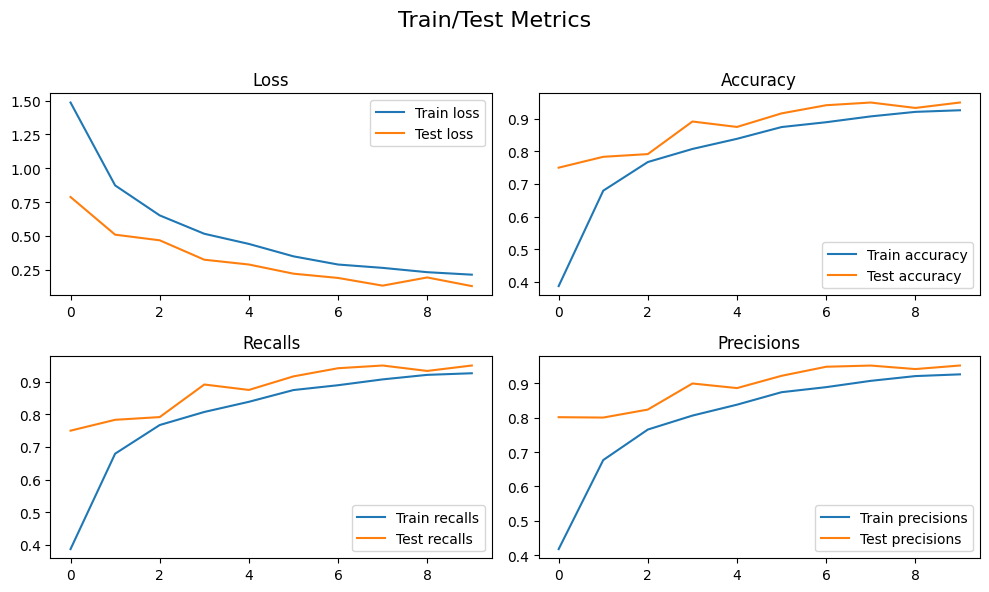

In [13]:
plot_metrics(metrics)